# Analysis

In this notebook we'll analyze the data we've extracted before. Our goal here is to get more insights into games that Hikaru played and check if "interesting" streak that GM Kramnik referred to contains any unusual patterns that may lead us to think that Hikaru may be cheating.

To understand some of the stats/data we are working here you have to be familiar with data we extracted and enriched in [data](data.ipynb). 

Here I'll just install some libs that we'll need for future work in this notebook.

In [622]:
!pip install pandas matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install tabulate
!pip install pingouin


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [623]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import seaborn as sns
import pingouin as pg

pd.options.mode.chained_assignment = None  # default='warn'


Load the data we have extracted

In [624]:
with open('./data/enriched/enriched_games_2023.jsonl', 'r') as json_file:
    all_games = [json.loads(line) for line in json_file]

and convert them into pandas data frame

In [625]:
all_games_df = pd.json_normalize(all_games)

Now we will add some more columns that may be useful for our statistic to this dataframe

In [626]:
all_games_df['win'] = all_games_df['hikaru_stats.win'] * 100
all_games_df['timeout_win'] = all_games_df['hikaru_stats.is_timeout_win'] * 100
all_games_df['win1'] = all_games_df['hikaru_stats.was_losing_gte_1_but_won'] * 100
all_games_df['win2'] = all_games_df['hikaru_stats.was_losing_gte_2_but_won'] * 100
all_games_df['win3'] = all_games_df['hikaru_stats.was_losing_gte_3_but_won'] * 100
all_games_df['win4'] = all_games_df['hikaru_stats.was_losing_gte_4_but_won'] * 100
all_games_df['win5'] = all_games_df['hikaru_stats.was_losing_gte_5_but_won'] * 100
all_games_df['hikaru_color'] = all_games_df.apply(lambda row: 'White' if row['white.username'] == "Hikaru"  else 'Black', axis=1)
all_games_df['draw'] = all_games_df.apply(lambda row: (True if row.get('white.result', None) in ['repetition', 'agreed', 'insufficient', 'stalemate', '50move', 'timevsinsufficient'] else False) * 100, axis=1)

def is_game_lost(row):
    color = row['hikaru_color'].lower()
    result = row[f'{color}.result']
    
    return True if result in ['resigned', 'timeout', 'checkmated'] else False

def get_win_reason(row):
    #get opponent color to get loosing reason
    if row['win'] == 100:
        color = 'white' if row['hikaru_color'].lower() == 'black' else 'black'
        return row[f'{color}.result']
    return None

all_games_df['win_reason'] = all_games_df.apply(lambda row: get_win_reason(row), axis=1)
all_games_df['loose'] = all_games_df.apply(lambda row: is_game_lost(row) * 100, axis=1)

all_games_df['hikaru_stats.good_moves_perc_sum'] = all_games_df['hikaru_stats.best_move_perc'] + all_games_df['hikaru_stats.excellent_move_perc'] + all_games_df['hikaru_stats.good_move_perc']
all_games_df['hikaru_stats.bad_moves_perc_sum'] = all_games_df['hikaru_stats.inaccuracy_move_perc'] + all_games_df['hikaru_stats.mistake_move_perc'] + all_games_df['hikaru_stats.blunder_move_perc']

all_games_df['opponent_stats.good_moves_perc_sum'] = all_games_df['opponent_stats.best_move_perc'] + all_games_df['opponent_stats.excellent_move_perc'] + all_games_df['opponent_stats.good_move_perc']
all_games_df['opponent_stats.bad_moves_perc_sum'] = all_games_df['opponent_stats.inaccuracy_move_perc'] + all_games_df['opponent_stats.mistake_move_perc'] + all_games_df['opponent_stats.blunder_move_perc']

bins = range(2000, 3500, 100)  # creating rating range buckets
all_games_df['rating_bin'] = pd.cut(all_games_df['hikaru_stats.opponent_rating'], bins=bins)
all_games_df['main_time_control'] = all_games_df['time_control'].apply(lambda x: int(x.split('+')[0]))
all_games_df['increment'] = all_games_df['time_control'].apply(lambda x: 0 if len(x.split('+')) == 1  else int(x.split('+')[1]))


Now we will isolate "interesting" streak games into separate DF.

In [627]:
start_streak_uuid = '5c232585-84b8-11ee-9446-6cfe544c0428'
end_streak_uuid = 'e565825f-858a-11ee-9c40-6cfe544c0428'

streak_start_index = all_games_df.index[all_games_df['uuid'] == start_streak_uuid].tolist()[0]
streak_end_index = all_games_df.index[all_games_df['uuid'] == end_streak_uuid].tolist()[0]
streak_games_df = all_games_df.iloc[streak_start_index:streak_end_index+1]

streak_games_df['time_control'].value_counts()


time_control
180    44
Name: count, dtype: int64

As observed, all 44 streak games are 3+0 blitz games. Now to have fair statistics, we will isolate all Hikaru's 3+0 streak games and exclude this interesting streak games so in our analysis we can compare one to another.

In [628]:

ids_to_exclude = streak_games_df['uuid'].tolist()

filtered_by_180_time_control_df = all_games_df.query('main_time_control == 180 & increment == 0')

blitz_180_no_streak_df = filtered_by_180_time_control_df[~filtered_by_180_time_control_df['uuid'].isin(ids_to_exclude)]
blitz_180_no_streak_df['time_control'].value_counts()

time_control
180    3640
Name: count, dtype: int64

So we have 3640 blitz 3+0 games that we will use as base for behaviour of Hikaru. In our analysis we will compare Hikaru's streak games to this data frame.

## On winning

In this section we'll cover some stats on win data. To start off, let see how often does Hikaru win and with what color does that happen more often. As blitz makes the majority of Hikarus games, we'll use all_blitz_df from now on to produce stats.

In [629]:
blitz_180_no_streak_df.groupby('hikaru_color').agg(
    {
        'win': 'mean',
        'draw': 'mean',
        'loose': 'mean',
        'timeout_win': 'mean'
     }
)

,win,draw,loose,timeout_win
hikaru_color,,,,
Black,78.037904,8.789386,12.714207,10.702341
White,82.984581,6.608411,9.939924,9.471366


What we see above is that Hikaru does have great win percentage in blitz, and it appears to be normally distributed for both piece colors. What is a little bit surprising is that Hikaru wins 78% of the time with black pieces as black is often considered as defensively oriented role. This shows that Hikaru has great chances of overturning roles in his games and winning lots of games even with black. 

Hikaru will loose only 13% of the time with black or 10% of the time with white pieces.

Also, what we see here is that ~1 out of 10 games Hikaru will win on time which means Hikaru is able to "flag" opponents quite often.

In [630]:
grouped_by_opponent = blitz_180_no_streak_df.groupby('hikaru_stats.opponent_username', observed=True)

grouped_by_opponent['hikaru_stats.opponent_username'].count().sort_values(ascending=False).head(5)

hikaru_stats.opponent_username
alexrustemov     117
artooon          108
NikoTheodorou     92
0gZPanda          84
Firouzja2003      80
Name: hikaru_stats.opponent_username, dtype: int64

These are 5 players Hikaru played against most. As we can tell he does play often against same players, let's now add their average elo rating.

In [631]:
top_5_opponents = grouped_by_opponent['hikaru_stats.opponent_username'].count().sort_values(ascending=False).head(5).index
top_5_df = blitz_180_no_streak_df[blitz_180_no_streak_df['hikaru_stats.opponent_username'].isin(top_5_opponents)]

top_5_df.groupby('hikaru_stats.opponent_username').agg({'hikaru_stats.opponent_rating': 'mean'}).loc[top_5_opponents]

,hikaru_stats.opponent_rating
hikaru_stats.opponent_username,
alexrustemov,2876.666667
artooon,2985.398148
NikoTheodorou,3051.717391
0gZPanda,3001.583333
Firouzja2003,3090.800000


We can tell that top two players have quite lower rating than Hikaru while others fluctuate around 3050 which is still significantly lower rating than what Hikaru has (~3200). Now such difference in rating on chess.com does not necessarily mean that Hikaru may win always against these opponents as they themselves are also strong GMs, however it does mean that Hikaru is better and has better experience in using chess.com platform.

Let's now add some other stats on these top 5. Primarily I want to see what is Hikaru win percentage against each of them and percentages on wins on time.

In [632]:
top_5_df['win'] = top_5_df['hikaru_stats.win'] * 100
top_5_df['timeout_win'] = top_5_df['hikaru_stats.is_timeout_win'] * 100

top_5_df.groupby('hikaru_stats.opponent_username').agg(
    {
        'hikaru_stats.opponent_rating': 'mean',
        'win': 'mean',
        'draw': 'mean',
        'loose': 'mean',
        'timeout_win': 'mean'
     }
).loc[top_5_opponents]


,hikaru_stats.opponent_rating,win,draw,loose,timeout_win
hikaru_stats.opponent_username,,,,,
alexrustemov,2876.666667,85.470085,6.837607,6.837607,29.059829
artooon,2985.398148,74.074074,8.333333,17.592593,1.851852
NikoTheodorou,3051.717391,56.521739,18.478261,25.000000,9.782609
0gZPanda,3001.583333,72.619048,9.523810,17.857143,4.761905
Firouzja2003,3090.800000,42.5,23.750000,33.750000,1.25


We can tell that winning percentage plays well with opponent rating, as higher the opponent rating is less likely it is for Hikaru to win. What surprised me is to see that against alexrustemov Hikaru won almost 30% of games on time. This is surprisingly large number and if anything it tells us that alexrustemov should work on his time management or stop playing Hikaru at all.

On other note Hikaru scored not so well against NikoTheodorou and Firouzja2003, winning just 56% and 41% which, compared to ratings, did result in Hikaru loosing his rating points.


What I want to see now is what is percentage of games that during the game Hikaru was loosing but won anyway. If you remember, in our data extraction we extracted 5 fields where hikaru was loosing by margins of 1,2,3,4,5 but won anyway so lets see this data.

In [633]:
top_5_df.groupby('hikaru_stats.opponent_username').agg(
    {
        'hikaru_stats.opponent_rating': 'mean',
        'win1': 'mean',
        'win2': 'mean',
        'win3': 'mean',
        'win4': 'mean',
        'win5': 'mean',
     }
).loc[top_5_opponents]

,hikaru_stats.opponent_rating,win1,win2,win3,win4,win5
hikaru_stats.opponent_username,,,,,,
alexrustemov,2876.666667,44.444444,20.512821,11.965812,8.547009,2.564103
artooon,2985.398148,28.703704,13.888889,8.333333,7.407407,7.407407
NikoTheodorou,3051.717391,39.130435,15.217391,8.695652,5.434783,2.173913
0gZPanda,3001.583333,39.285714,14.285714,8.333333,7.142857,4.761905
Firouzja2003,3090.800000,25.0,12.5,8.75,3.75,2.5


The provided statistics align with expectations, and no unusual patterns are present. Hikaru Nakamura does have some chance of winning even when faced with a disadvantageous position. Nevertheless, as the evaluation indicating a losing position increases, his likelihood of winning decreases.

Let's now look at entire dataset but first lets split it into rating range buckets.

In [634]:
blitz_180_no_streak_df.groupby('rating_bin', observed=True)['hikaru_stats.opponent_rating'].count()

rating_bin
(2000, 2100]      15
(2100, 2200]      16
(2200, 2300]      20
(2300, 2400]      28
(2400, 2500]      69
(2500, 2600]      87
(2600, 2700]     162
(2700, 2800]     214
(2800, 2900]     906
(2900, 3000]    1170
(3000, 3100]     683
(3100, 3200]      92
(3200, 3300]       2
Name: hikaru_stats.opponent_rating, dtype: int64

<Figure size 1500x600 with 0 Axes>

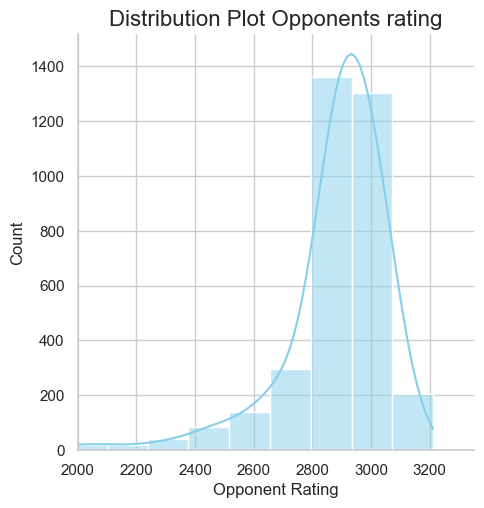

In [635]:
sns.set(style="whitegrid")

plt.figure(figsize=(15, 6))
sns.displot(blitz_180_no_streak_df['hikaru_stats.opponent_rating'], kde=True, bins=20, color='skyblue')

# Title and labels
plt.title('Distribution Plot Opponents rating', fontsize=16)
plt.xlabel('Opponent Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlim(2000)

# Show the plot
plt.show()

As we can tell from the distribution above, it is clear that a significant portion of his matches is against opponents with notably lower ratings, potentially contributing to his proficiency in farming elo rating. Typically, his opponents fall within the rating range of 2500 to 3200. However, the majority of his games are concentrated within the narrower span of 2800 to 3000.

Now, let's delve into additional statistics specific to each rating range.


In [636]:
blitz_180_no_streak_df.groupby('rating_bin', observed=True).agg(
    {
        'win': 'mean',
        'draw': 'mean', 
        'loose': 'mean', 
        'timeout_win': 'mean',
        'win1': 'mean',
        'win2': 'mean',
        'win3': 'mean',
        'win4': 'mean',
        'win5': 'mean',
     }
)


,win,draw,loose,timeout_win,win1,win2,win3,win4,win5
rating_bin,,,,,,,,,
"(2000, 2100]",93.333333,0.000000,0.000000,0.0,60.0,46.666667,26.666667,13.333333,6.666667
"(2100, 2200]",68.75,0.000000,6.250000,0.0,43.75,37.5,31.25,25.0,18.75
"(2200, 2300]",100.0,0.000000,0.000000,25.0,60.0,40.0,40.0,35.0,20.0
"(2300, 2400]",78.571429,0.000000,7.142857,14.285714,53.571429,32.142857,25.0,21.428571,17.857143
"(2400, 2500]",98.550725,0.000000,1.449275,13.043478,50.724638,26.086957,21.73913,17.391304,14.492754
"(2500, 2600]",91.954023,2.298851,4.597701,11.494253,54.022989,37.931034,24.137931,19.54023,16.091954
"(2600, 2700]",94.444444,1.851852,3.086420,11.111111,51.851852,27.777778,19.135802,13.580247,11.728395
"(2700, 2800]",95.327103,2.336449,2.336449,10.280374,44.859813,22.897196,17.28972,13.084112,8.878505
"(2800, 2900]",89.403974,5.298013,5.187638,13.245033,44.15011,23.509934,15.562914,11.92053,8.278146


The statistics within each rating range appear consistent with expectations. Generally, as Hikaru's opponent rating range increases he does have less chance of winning. Same apply for situations where Hikaru was loosing but won at the end; as the higher opponent elo is it is harder for Hikaru to make comeback from loosing position. 

Let's now see these stats for the "interesting" streak games and see if they deviate from what we saw so far. We'll also take a subset from above table which is relevant for streak games.

In [637]:
blitz_180_no_streak_agg_df = blitz_180_no_streak_df.groupby('rating_bin', observed=True).agg(
    {
        'win': ['count', 'mean'],
        'timeout_win': 'mean',
        'win1': 'mean',
        'win2': 'mean',
        'win3': 'mean',
        'win4': 'mean',
        'win5': 'mean',
     }
).iloc[9:11, :]
blitz_180_no_streak_agg_df

win            timeout_win       win1       win2       win3  \
             count       mean        mean       mean       mean       mean   
rating_bin                                                                   
(2900, 3000]  1170  78.547009    9.230769  39.059829  19.401709  12.991453   
(3000, 3100]   683  62.518302    8.931186  34.407028   17.27672  12.005857   

                  win4      win5  
                  mean      mean  
rating_bin                        
(2900, 3000]  9.316239  6.239316  
(3000, 3100]  8.784773  6.149341

In [638]:
streak_agg_df = streak_games_df.groupby('rating_bin', observed=True).agg(
    {
        'win': ['count', 'mean'],
        'timeout_win': 'mean',
        'win1': 'mean',
        'win2': 'mean',
        'win3': 'mean',
        'win4': 'mean',
        'win5': 'mean',
     }
)
streak_agg_df

win            timeout_win       win1       win2       win3  \
             count       mean        mean       mean       mean       mean   
rating_bin                                                                   
(2900, 3000]    38  97.368421   18.421053  47.368421  21.052632  18.421053   
(3000, 3100]     6      100.0   16.666667       50.0  33.333333  16.666667   

                   win4      win5  
                   mean      mean  
rating_bin                         
(2900, 3000]  13.157895  7.894737  
(3000, 3100]  16.666667       0.0

Here we can see that streak games do have higher numbers compared to overall dataset. However, as we cherry-picked specific winning streak such differences do not have to be necessarily an unusual pattern. Fact that all these cherry-picked games likely play a role in seeing these numbers higher than what we see in entire data set. However, it does mean that ~8% of the time, when played 2900-3000 rating during his streak, Hikaru was lost by 8 but won anyway. Let's find these wins and what was a winning reason.

In [639]:
streak_games_df.query('win5 == 100').groupby('rating_bin', observed=True)['win_reason'].value_counts()

rating_bin    win_reason
(2900, 3000]  timeout       2
              resigned      1
Name: count, dtype: int64

So there were 3 games where Hikaru was loosing by 5 and won anyway. Two of them he won on time, frequently referred as flagged opponent. In last one his opponent resigned, so lets look a specific details of this game. Let's pull this game and see if there is anything unusual with it.

In [640]:
lost_by_5_but_won = streak_games_df.query('win5 == 100 & win_reason == "resigned"').head(1)
lost_by_5_but_won[['url','hikaru_stats.opponent_username', 'hikaru_stats.good_moves_perc_sum', 'hikaru_stats.bad_moves_perc_sum', 'opponent_stats.good_moves_perc_sum', 'opponent_stats.bad_moves_perc_sum']]

,url,hikaru_stats.opponent_username,hikaru_stats.good_moves_perc_sum,hikaru_stats.bad_moves_perc_sum,opponent_stats.good_moves_perc_sum,opponent_stats.bad_moves_perc_sum
4158,https://www.chess.com/game/live/93910817501,LiamPutnam2008,82.608696,17.391304,80.434783,19.565217


Apparently this game was played against LiamPutnam2008. You can check game details on https://www.chess.com/game/live/93910817501 but what I found out is that on move 29 Hikaru made serious mistake of playing Bd8.
<br>
<img src="data/photos/liamputnam_game_loosing_5plus.png" width="1200" height="800" />

At this point Hikaru was lost by 5+ eval. Several moves have been played after this move where both sides were making mistakes, however Liamputnam2008 did make a crucial blunder loosing a knight which lead him to loose the game. Hikaru did spend 2 seconds on playing move which took advantage on the blunder and the move itself does not seem too hard to find even for my limited chess knowledge. 

At this point I do not see anything unusual with this game but that LiamPutnam2008 did really play a bad game and let Hikaru win even though he was practically lost. I did check fide ratings for Liam Putnam and his blitz rating in fide list is 2157 therefore it does make sense for Hikaru to keep playing even though he was lost in middlegame as he has a lot of chances to win these games being overrated and better player in general.

After we checked games where Hikaru was lost by 5+ but won anyway in streak games, lest also check what are common winning reasons for all loosing but won buckets.

In [641]:
# Win 5 we have already covered
lost_by_N_but_won = streak_games_df.query('(win1 == 100 | win2 == 100 | win3 == 100 | win4 == 100) & win5 != 100')
lost_by_N_but_won['win_reason'].value_counts()

win_reason
resigned    13
timeout      5
Name: count, dtype: int64

So out of 18 games, 13 were won by resignation of opponent and 5 were won on timeout. Again, timeout wins are not really interesting to us as Hikaru was able to flag opponents, however we want to get some more insights in these 13 so lets start by seeing their move's percentage.

In [642]:
lost_by_N_but_won_by_resignation = lost_by_N_but_won.query('win_reason == "resigned"')

lost_by_N_but_won_by_resignation_renamed = lost_by_N_but_won_by_resignation.rename(columns={
    'hikaru_stats.opponent_username': 'Opponent',
    'hikaru_stats.opponent_rating': 'Opponent elo',
    'hikaru_stats.total_moves': 'Moves count',
    'hikaru_stats.good_moves_perc_sum': 'Hikaru good moves %',
    'hikaru_stats.bad_moves_perc_sum': 'Hikaru bad moves %',
    'opponent_stats.good_moves_perc_sum':  'Opponent Good moves %',
    'opponent_stats.bad_moves_perc_sum': 'Opponent bad moves %',
    'opponent_stats.blunder_move_perc': 'Opponent blunders %'
})

lost_by_N_but_won_by_resignation_renamed[['Opponent', 'Opponent elo', 'Moves count', 'Hikaru good moves %', 'Hikaru bad moves %', 'Opponent Good moves %', 'Opponent bad moves %', 'Opponent blunders %', 'url' ]]


,Opponent,Opponent elo,Moves count,Hikaru good moves %,Hikaru bad moves %,Opponent Good moves %,Opponent bad moves %,Opponent blunders %,url
4146,Artur0208,2912.0,23.0,92.307692,7.692308,76.923077,23.076923,7.692308,https://www.chess.com/game/live/93903575753
4147,Artur0208,2910.0,45.0,71.428571,28.571429,67.647059,32.352941,2.941176,https://www.chess.com/game/live/93903652211
4149,Pe0la,2995.0,36.0,69.230769,30.769231,69.230769,30.769231,7.692308,https://www.chess.com/game/live/93904261273
4156,LiamPutnam2008,2913.0,43.0,78.787879,21.212121,72.727273,27.272727,6.060606,https://www.chess.com/game/live/93910207781
4157,LiamPutnam2008,2911.0,68.0,84.482759,15.517241,84.210526,15.789474,3.508772,https://www.chess.com/game/live/93910727787
4161,LiamPutnam2008,2911.0,86.0,82.894737,17.105263,86.666667,13.333333,1.333333,https://www.chess.com/game/live/93912033813
4164,LiamPutnam2008,2905.0,22.0,75.000000,25.000000,66.666667,33.333333,8.333333,https://www.chess.com/game/live/93913173895
4170,Pe0la,2951.0,31.0,90.476190,9.523810,80.952381,19.047619,4.761905,https://www.chess.com/game/live/93977049041
4171,Pe0la,2947.0,39.0,82.758621,17.241379,75.000000,25.000000,7.142857,https://www.chess.com/game/live/93977534149
4172,Pe0la,2943.0,42.0,87.500000,12.500000,81.250000,18.750000,3.125000,https://www.chess.com/game/live/93977612015


Let's analyze these 13 games, first by checking into the stats we have and then if necessarily by checking in details some games. 
<br>


##### First 4 games

First 4 games in table above (sorted by moves count) seem to be regular games where opponent (likely due to tilt factor) blundered early and resigned game figuring out it would be hard for them to recover vs Hikaru. In 2 of them Hikaru did perform by having 90%+ good moves percentage. However, give the low amount of played moves it is hard to judge these games as even all of these could be Hikaru's preparation or opening theory.

<br>

##### 4171 - Game against Pe0la 

In this [game](https://www.chess.com/game/live/93977534149) Hikaru was lost by 2+. The game itself had 39 moves and on move 27 Pe0la made a blunder which gave Hikaru chance to survive and even out odds. Hikaru did make a best move taking 12 seconds to play it. Hikaru had more than 1 minute left on his clock when he made this move while his opponent did have 35 seconds left so likely Hikaru did not feel time pressure. The move itself does not seem to be hard to find, and it is classified by best by chess.com not great nor brilliant. After this move Pe0la made several bad moves allowing Hikaru to take advantage and win at the end.

As I said above, the move does not seem to be hard to find. However, it did took Hikaru 12 seconds to play which (as we will cover below in section on moves) is long time for Hikaru. 

<br>

##### Rest of the games

I will not do this analysis for all the 13 games, however I did check few more samples and it does seem that it is usually up to the opponents that make a bad moves and not up to Hikaru to make good moves. Usually these players will make a bunch of mistakes in middlegame where Hikaru will play just regular (obvious) good moves without burning a lot of time. Also, in lots of these games opponents may be feeling time pressure as Hikaru will usually play fast and be in a big advantage on clock.



### On winning summary

So far we did see some "interesting" and a lot of non "interesting" stats. GM Hikaru is usually playing lower rated players, and he does win a lot. When playing such players he does have less stress as he can more easily make comeback from worst position. Hikaru will usually play fast, and beat opponents on clock or put a lot of stress on them due to time advantage. More often it is up to the opponents who make a bad moves and loose their advantage then it is up to Hikaru of making good moves.

Against higher rated players Hikaru would have much lower chances on making such streak as he does win much less and have fewer chances to recover from worst position.

Let's now move to analyze moves data within these games.

## On moves

Here we will examine moves statistic and compare in with other data in our datasets. More specifically we want to see how many good moves Hikaru plays under which condition and how does that affect his winning chances. If you remember, during our data extraction we did extract some stats on move classification which ranges from Excellent - Blunder, however we also did add stats on a column which represent whether the specific move was one of the top 2 moves offered by stockfish.
<br>
### Top two moves percentage

Let's start by plotting distribution of top 2 moves percentage accross games.

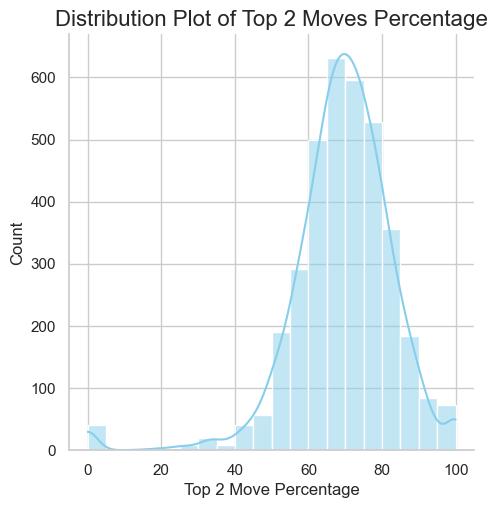

In [643]:
sns.displot(blitz_180_no_streak_df['hikaru_stats.top_2_move_perc'], kde=True, bins=20, color='skyblue')

plt.title('Distribution Plot of Top 2 Moves Percentage', fontsize=16)
plt.xlabel('Top 2 Move Percentage', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

In [644]:
blitz_180_no_streak_df['hikaru_stats.top_2_move_perc'].describe()

count    3610.000000
mean       69.218825
std        13.908631
min         0.000000
25%        62.500000
50%        70.000000
75%        77.577410
max       100.000000
Name: hikaru_stats.top_2_move_perc, dtype: float64

We can tell that data is sort of normally distributed and that majority of games did have top two moves percentage between 60% and 80%. However, standard deviation for this type of data (percentages) seem to be high as two standard deviations cover anything in between 40% - 97% and based on distribution graph from above we can tell that < 40% are rare games.
 
What this means is that in 68% of the games Hikaru did play top two moves for ~ 60%-80% of the time, and in 95% of the games Hikaru did play top two moves for ~ 40%-100% of the time. As we can tell, this data is pretty much scattered around therefore does not tell us a lot.

Let's now see best move percentage per elo rating range and if that tells us more.

In [645]:
blitz_180_no_streak_df.groupby('rating_bin', observed=True)['hikaru_stats.top_2_move_perc'].describe()

,count,mean,std,min,25%,50%,75%,max
rating_bin,,,,,,,,
"(2000, 2100]",15.0,47.356196,26.803064,0.000000,41.477273,57.142857,64.796905,80.000000
"(2100, 2200]",16.0,61.087322,19.647127,30.000000,49.456522,60.882353,73.557692,92.857143
"(2200, 2300]",20.0,70.386435,17.504059,30.769231,59.285714,69.176636,85.178571,100.000000
"(2300, 2400]",28.0,69.098148,14.425222,45.833333,56.493506,69.917744,80.654762,100.000000
"(2400, 2500]",69.0,72.625674,11.992061,46.511628,63.157895,73.076923,80.645161,100.000000
"(2500, 2600]",87.0,71.907957,13.611550,0.000000,66.666667,72.340426,78.835386,100.000000
"(2600, 2700]",162.0,71.541213,13.216270,0.000000,65.000000,71.428571,78.907496,100.000000
"(2700, 2800]",214.0,71.642510,12.789581,0.000000,64.479167,72.000000,79.274425,100.000000
"(2800, 2900]",906.0,70.392339,11.723153,0.000000,63.157895,70.588235,77.777778,100.000000


Here we got a little bit more accurate numbers but still high standard deviation. Let's now see a stats for streak games and compare them to non streak games.


In [646]:
streak_games_df.groupby('rating_bin', observed=True)['hikaru_stats.top_2_move_perc'].describe()

,count,mean,std,min,25%,50%,75%,max
rating_bin,,,,,,,,
"(2900, 3000]",38.0,73.923109,12.487260,48.571429,65.885417,71.008403,81.010347,100.00000
"(3000, 3100]",6.0,75.801808,11.228014,63.333333,66.617399,74.647177,84.486418,90.47619


We can tell that there is some difference by looking at the mean and standard deviation. We will now focus on 2900-3000 rating ranges and calculate coefficient of variation and compare streak games to non streak games.

The coefficient of variation (CV) is a relative measure of dispersion, and it tells us relative variability of each dataset. What we want to see is how different streak games CV is to the non streak games CV.

In [647]:
first_group_index = list(streak_games_df.groupby('rating_bin', observed=True).groups)[0]

streak_2900_3000 = streak_games_df.groupby('rating_bin', observed=True).get_group(first_group_index)['hikaru_stats.top_2_move_perc']

first_group_index = list(blitz_180_no_streak_df.groupby('rating_bin', observed=True).groups)[9]

no_streak_2900_3000 = blitz_180_no_streak_df.groupby('rating_bin', observed=True).get_group(first_group_index)['hikaru_stats.top_2_move_perc']

def calculate_cv(df):
    mean = df.mean()
    std = df.std()
    return (std/mean) * 100

print(f'Coefficient of variation for streak games is {calculate_cv(streak_2900_3000)} compared to non streak games {calculate_cv(no_streak_2900_3000)}')


Coefficient of variation for streak games is 16.89222775369165 compared to non streak games 16.143324727907306


As seen above both streak and non streak games have similar variability where their coefficient of variation is around 16%. As there is no high difference in variability we will expect that streak games do have similar properties to the non streak games in regard to top two moves percentage.

Let's now plot mean of top two percentage moves for both datasets we're working with.
We want to see if there is significant difference in mean of streak games when compared to other blitz games for rating range.

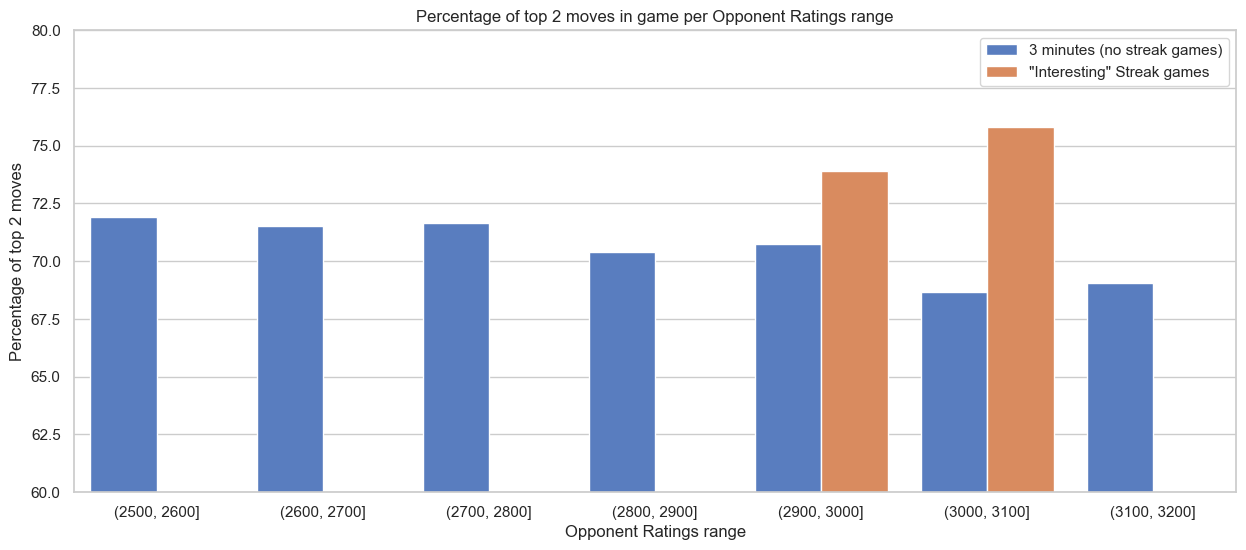

In [648]:
average_percentage_streak_games = streak_games_df.groupby('rating_bin', observed=True)['hikaru_stats.top_2_move_perc'].mean().reset_index()
average_percentage_blitz_180_no_streak = blitz_180_no_streak_df.groupby('rating_bin', observed=True)['hikaru_stats.top_2_move_perc'].mean().reset_index()

plt.figure(figsize=(15, 6))

combined_df = pd.concat([average_percentage_blitz_180_no_streak, average_percentage_streak_games], keys=['3 minutes (no streak games)', '"Interesting" Streak games'], names=['DataFrame']).reset_index()

sns.barplot(x='rating_bin', y='hikaru_stats.top_2_move_perc', hue='DataFrame', data=combined_df, palette='muted')

plt.title('Percentage of top 2 moves in game per Opponent Ratings range')
plt.xlabel('Opponent Ratings range')
plt.ylabel('Percentage of top 2 moves')
plt.axis([4.5, 11.5, 60, 80])
plt.legend()
plt.show()

Here we can tell that there is a difference in percentage of top 2 moves per game when we compare streak games vs blitz games. For elo rating range 2900 - 3000 difference is about 3% and for elo rating range 3000 - 3100 is about 7%. We can also see that majority of streak games are played for 2900 - 3000 elo rating range and only 6 games where Hikaru players were in elo range of 3000 - 3100. However, these percentage still fall into range of 60% - 80%.

We can also see that as the opponents rating elo increases best moves percentage of Hikaru slightly decreases.


In [649]:
bucket_one_diff = average_percentage_streak_games['hikaru_stats.top_2_move_perc'][0] - average_percentage_blitz_180_no_streak['hikaru_stats.top_2_move_perc'][9]
bucket_two_diff = average_percentage_streak_games['hikaru_stats.top_2_move_perc'][1] - average_percentage_blitz_180_no_streak['hikaru_stats.top_2_move_perc'][10]

print(f'Difference for elo rating range 2900 - 3000 is {bucket_one_diff}')
print(f'Difference for elo rating range 3000 - 3100 is {bucket_two_diff}')

Difference for elo rating range 2900 - 3000 is 3.1588837167025474
Difference for elo rating range 3000 - 3100 is 7.119885656978184


Let's try to isolate games from the streak which don't fall within one standard deviation of top 2 moves percentage and check on them.

In [650]:
std = blitz_180_no_streak_df['hikaru_stats.top_2_move_perc'].std()
mean = blitz_180_no_streak_df['hikaru_stats.top_2_move_perc'].mean()

not_within_std = streak_games_df[(streak_games_df['hikaru_stats.top_2_move_perc'] < mean - std) | (streak_games_df['hikaru_stats.top_2_move_perc'] > mean + std)]
not_within_std[['hikaru_stats.opponent_username', 'hikaru_stats.opponent_rating', 'hikaru_stats.total_moves', 'hikaru_stats.top_2_move_perc', 'url']]

,hikaru_stats.opponent_username,hikaru_stats.opponent_rating,hikaru_stats.total_moves,hikaru_stats.top_2_move_perc,url
4146,Artur0208,2912.0,23.0,84.615385,https://www.chess.com/game/live/93903575753
4147,Artur0208,2910.0,45.0,48.571429,https://www.chess.com/game/live/93903652211
4150,Pe0la,2986.0,25.0,100.000000,https://www.chess.com/game/live/93904764593
4154,Pe0la,2980.0,11.0,100.000000,https://www.chess.com/game/live/93908308759
4160,LiamPutnam2008,2913.0,71.0,86.885246,https://www.chess.com/game/live/93911943083
4167,Pe0la,2964.0,13.0,100.000000,https://www.chess.com/game/live/93976399237
4170,Pe0la,2951.0,31.0,85.714286,https://www.chess.com/game/live/93977049041
4176,artin10862,2922.0,24.0,92.857143,https://www.chess.com/game/live/93983582243
4178,artin10862,2918.0,20.0,90.000000,https://www.chess.com/game/live/93984157067
4182,artin10862,2910.0,29.0,84.210526,https://www.chess.com/game/live/93985321261


There are 12 games from the "interesting" streak games where top 2 moves percentage is outside standard deviation. Some of these moves do have relatively small amount of moves that we take in consideration when calculating move ratings (we ignore first 10 moves as we consider them opening phase. Check data notebook for more on this). However, some of these games do have high percentage of top 2 moves even with higher number of moves therefore we will take sample of them to analyze.

<br>

##### Game 4150 Hikaru - Pe0la
This is 25 moves game and top two moves percentage made by Hikaru is 100%. This essentially means that last 15 moves of the game Hikaru played one of the two moves that are classified as best by stockfish. This game Hikaru won with accuracy of 97.4 with 4 great moves being played. 
First great move is on move 18 where Hikaru played Ra1:

<br>

<img src="data/photos/case2/great-move-1.png" width="700" height="700" />

<br>

Apparently this is first time in the game where Hikaru used more time for thinking, and it took him 23 seconds to play this move. The next great move made by Hikaru is on move 20 where he also took significant thinking time of 22 seconds.

<br> 

<img src="data/photos/case2/great-move-2.png" width="700" height="700" />

<br>

Next two greate moves were made rather instantaneously and game was quickly over after 25th move. Note that, even when taking longer thinking time on these two great moves Hikaru was still up on clock against his opponent which demonstrates excellent time management skills. 

<br><br>

##### Game 4186 Hikaru - legendisback1

In this game Hikaru in his opponent played 31 move where, even though he made one blunder which his opponent didn't take advantage of, Hikaru won with 93.9 accuracy. Advantage was given to Hikaru by his opponent on move 25 where he played bxc5.
<br> 

<img src="data/photos/case3/opponent_mistake_1.png" width="700" height="700" />

<br>

Hikaru played the best obvious move dxc5 instantly and his opponent quickly played Rb8 move. After this Hikaru took 36 seconds to play next move (b6) which according to stockfish evaluation is the best one and keeps advantage.

<br>
<img src="data/photos/case3/best_move_1.png" width="700" height="700" />
<br>

Shortly after this Hikaru was able to keep and increase his advantage which lead him to win on move 31. Similarly to the previous example, Hikaru was better on clock in this game and could afford spending time in such situations.

<br>

Even though we can see there are key situations where Hikaru took some time for thinking and played best moves it is not unusual for GM such as Hikaru to sense the key moments and spend more time on calculating variations. Given that Hikaru does play rather quickly he is able to "save" some time for later use when he can sense the moment may be key moment for thinking. 

Let's now go to another feature in our dataset which is subset of top two moves, only moves.


### Only moves 

Remember that in our data preparation we have extracted moves that we categorized as "only move". These are moves that beside being in top two, are in classification of excellent or best and do take advantage on fact that previous move by opponent was not good (in bad category). We want to compare how often does Hikaru recognize that opponent made a bad move and play against it with best moves to either make a comeback or increase winning chances. As in the previous analysis, lets start by plotting the distribution of only moves percentage across our games.

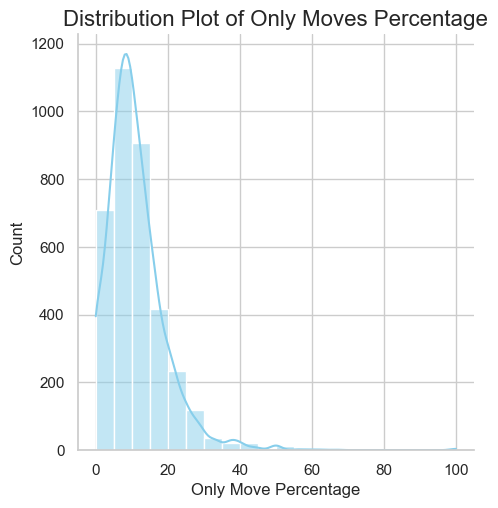

In [651]:
sns.displot(blitz_180_no_streak_df['hikaru_stats.only_move_perc'], kde=True, bins=20, color='skyblue')

plt.title('Distribution Plot of Only Moves Percentage', fontsize=16)
plt.xlabel('Only Move Percentage', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

In [652]:
blitz_180_no_streak_df['hikaru_stats.only_move_perc'].describe()

count    3610.000000
mean       11.127432
std         8.292817
min         0.000000
25%         5.882353
50%         9.677419
75%        14.705882
max       100.000000
Name: hikaru_stats.only_move_perc, dtype: float64

We can tell that unlike top two moves, only moves are much rarer in these games as majority of them is placed between 2% - 20% of all the moves. This also does make sense as only move does require previous opponent move to be a bad move which is not case for top two moves. Lets now see same data grouped by rating range.

In [653]:
blitz_180_no_streak_df.groupby('rating_bin', observed=True)['hikaru_stats.only_move_perc'].describe()

,count,mean,std,min,25%,50%,75%,max
rating_bin,,,,,,,,
"(2000, 2100]",15.0,7.920781,8.961411,0.000000,0.000000,8.510638,13.118280,25.000000
"(2100, 2200]",16.0,14.080060,9.581381,0.000000,6.785714,13.025210,18.870192,33.333333
"(2200, 2300]",20.0,14.115143,13.855119,2.040816,6.895604,10.882353,16.810345,66.666667
"(2300, 2400]",28.0,16.983357,12.162995,0.000000,8.333333,15.740741,22.916667,50.000000
"(2400, 2500]",69.0,15.111336,8.641873,0.000000,8.695652,14.814815,19.354839,40.000000
"(2500, 2600]",87.0,11.802013,12.142225,0.000000,5.825792,9.756098,14.760349,100.000000
"(2600, 2700]",162.0,11.582838,7.983028,0.000000,6.642171,10.172414,15.113636,50.000000
"(2700, 2800]",214.0,13.513183,8.641789,0.000000,7.882353,11.952381,17.647059,55.555556
"(2800, 2900]",906.0,12.079162,8.231529,0.000000,6.666667,10.690476,15.453297,100.000000


The trend that we saw with best moves is somewhat present here as well. As opponent rating is higher, average percentage of only moves tends to be smaller. For rating range of our interest (2900 - 3100) average is around 10% with standard deviation of 7.4. Let's now compare and plot this data with streak games to see if there are any unusual patterns and outliers in streak games.

In [654]:
streak_games_df.groupby('rating_bin', observed=True)['hikaru_stats.only_move_perc'].describe()

,count,mean,std,min,25%,50%,75%,max
rating_bin,,,,,,,,
"(2900, 3000]",38.0,15.332037,15.672861,3.846154,8.235125,11.715686,15.109890,100.000000
"(3000, 3100]",6.0,15.053870,4.175864,8.108108,13.439850,15.476190,18.229167,19.354839


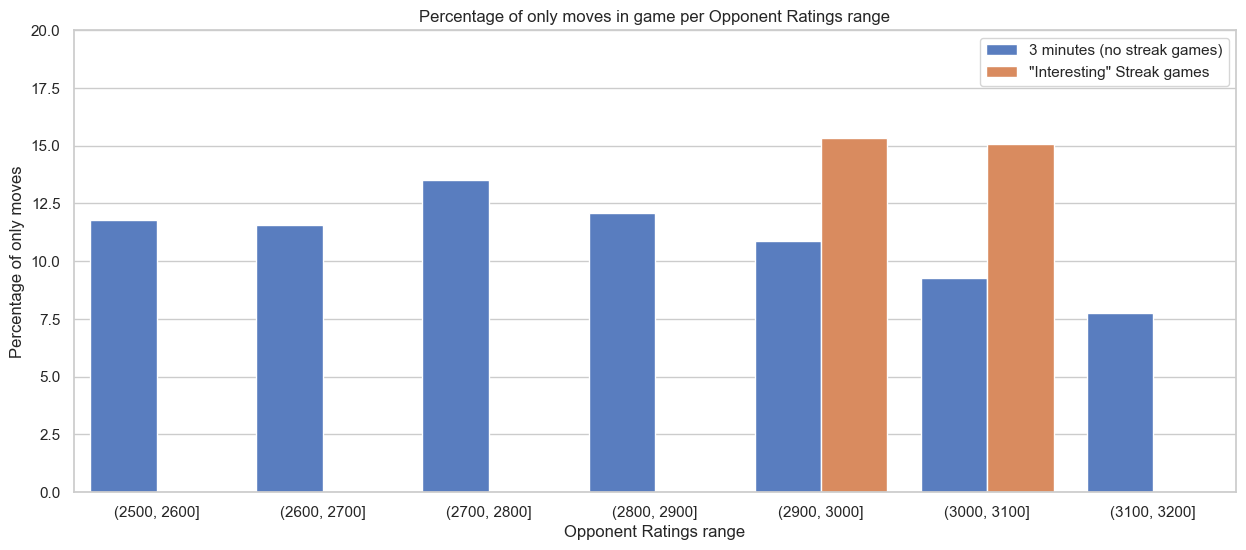

In [655]:
average_percentage_streak_games = streak_games_df.groupby('rating_bin', observed=True)['hikaru_stats.only_move_perc'].mean().reset_index()
average_percentage_blitz_180_no_streak = blitz_180_no_streak_df.groupby('rating_bin', observed=True)['hikaru_stats.only_move_perc'].mean().reset_index()

plt.figure(figsize=(15, 6))

combined_df = pd.concat([average_percentage_blitz_180_no_streak, average_percentage_streak_games], keys=['3 minutes (no streak games)', '"Interesting" Streak games'], names=['DataFrame']).reset_index()

sns.barplot(x='rating_bin', y='hikaru_stats.only_move_perc', hue='DataFrame', data=combined_df, palette='muted')

plt.title('Percentage of only moves in game per Opponent Ratings range')
plt.xlabel('Opponent Ratings range')
plt.ylabel('Percentage of only moves')
plt.axis([4.5, 11.5, 0, 20])
plt.legend()
plt.show()

Similarly to the top two moves, here as well we can see a difference in averages when we compare streak and non streak games. More interesting is that in at least one game Hikaru did have 100% of only moves, we will definitely be checking that one. So lets start with the same approach we used before, find outliers in streak games compared to non streak metrics and hand check them.

In [656]:
std = blitz_180_no_streak_df['hikaru_stats.only_move_perc'].std()
mean = blitz_180_no_streak_df['hikaru_stats.only_move_perc'].mean()

not_within_std = streak_games_df[(streak_games_df['hikaru_stats.only_move_perc'] < mean - std) | (streak_games_df['hikaru_stats.only_move_perc'] > mean + std)]
not_within_std[['hikaru_stats.opponent_username', 'hikaru_stats.opponent_rating', 'hikaru_stats.total_moves', 'hikaru_stats.only_move_perc', 'url']]

,hikaru_stats.opponent_username,hikaru_stats.opponent_rating,hikaru_stats.total_moves,hikaru_stats.only_move_perc,url
4146,Artur0208,2912.0,23.0,23.076923,https://www.chess.com/game/live/93903575753
4150,Pe0la,2986.0,25.0,20.000000,https://www.chess.com/game/live/93904764593
4154,Pe0la,2980.0,11.0,100.000000,https://www.chess.com/game/live/93908308759
4164,LiamPutnam2008,2905.0,22.0,25.000000,https://www.chess.com/game/live/93913173895
4167,Pe0la,2964.0,13.0,33.333333,https://www.chess.com/game/live/93976399237
4173,Pe0la,2939.0,30.0,20.000000,https://www.chess.com/game/live/93978138493
4178,artin10862,2918.0,20.0,30.000000,https://www.chess.com/game/live/93984157067
4179,artin10862,2916.0,19.0,22.222222,https://www.chess.com/game/live/93984197957


So there are 8 games played by Hikaru in streak which our not within one standard deviation of all other 3+0 games. Some of them do have relatively small number of moves and given that we do not count opening moves these games are not relevant. For example, 100% only move game had 11 moves, which means it played only one move out of our opening move filter, and it was only move. However, we want to look at few games that do have higher number of total moves but still high percentage of only moves.

<br>

##### 4173 - Hikaru vs Pe0la

This is game in our outliers set which does have most moves, however I could not find anything "interesting" in this game. Only move that is worth reviewing was in the endgame when Pe0la did make a mistake by playing e5 with his pawn, basically giving Hikaru a pawn and big advantage. Hikaru did spend 5 seconds on playing best move there, but situation itself does not seem to be that complicated to me. Hikaru did end this game having 1.52 minute left on clock while his opponent was at 0.52.

<br> 

<img src="data/photos/case4/mistake_move.png" width="700" height="700" />

<br>

##### 4146 - Hikaru vs Artur0208

In this game Hikaru had 93.1% of accuracy and did have 2 brilliant and 2 great moves. The game at the end was full of tactics Hikaru found on his opponent and did have a great advantage. However, only moves were played rather quickly, and personally I do not see anything weird in only moves behaviour for this game. Hikaru did end the game with 1.37 minute left on clock while his opponent had 37 seconds.

<br>

Now that we saw averages of only moves per all game moves, let's see these averages relative to possible amount of only moves.

In [657]:
blitz_180_no_streak_df.groupby('rating_bin', observed=True)['hikaru_stats.only_move_relative_perc'].describe()


,count,mean,std,min,25%,50%,75%,max
rating_bin,,,,,,,,
"(2000, 2100]",15.0,26.018519,27.137800,0.000000,0.000000,25.000000,50.000000,66.666667
"(2100, 2200]",16.0,38.623737,23.796130,0.000000,24.305556,33.333333,54.166667,83.333333
"(2200, 2300]",20.0,51.547619,24.420231,16.666667,33.333333,43.650794,61.666667,100.000000
"(2300, 2400]",28.0,52.820939,24.469027,0.000000,41.250000,50.000000,68.750000,100.000000
"(2400, 2500]",69.0,53.211177,23.565825,0.000000,37.500000,50.000000,66.666667,100.000000
"(2500, 2600]",87.0,45.627393,25.627323,0.000000,33.333333,42.857143,62.019231,100.000000
"(2600, 2700]",162.0,48.963968,23.299961,0.000000,33.333333,50.000000,61.875000,100.000000
"(2700, 2800]",214.0,53.485761,24.653920,0.000000,37.500000,50.000000,66.666667,100.000000
"(2800, 2900]",906.0,49.939387,21.996021,0.000000,33.333333,50.000000,62.500000,100.000000


In [658]:
streak_games_df.groupby('rating_bin', observed=True)['hikaru_stats.only_move_relative_perc'].describe()

,count,mean,std,min,25%,50%,75%,max
rating_bin,,,,,,,,
"(2900, 3000]",38.0,58.583281,24.237840,20.000000,38.541667,57.272727,75.000,100.000000
"(3000, 3100]",6.0,56.112637,17.553976,38.461538,42.500000,55.000000,61.875,85.714286


We can tell that in both cases mean is around 50% but is greater in streak games. This means that in average Hikaru did take more only moves after his opponent made a bad move. However, we can see that standard deviation for both datasets is significantly high meaning data is spread around pretty much everywhere.

Let's see the timeline over streak games and does it relate to percentage of only moves taken.



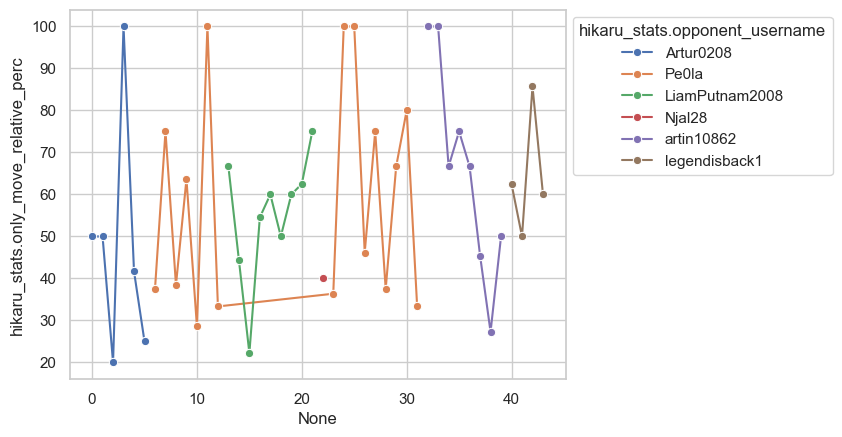

In [659]:
reindexed_df = streak_games_df.reset_index()

ax = sns.lineplot(x=reindexed_df.index, y='hikaru_stats.only_move_relative_perc', data=streak_games_df, marker='o', hue='hikaru_stats.opponent_username')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

As we can tell there is no clear pattern even if we look per opponent. Data is very dispersed and there is no trend within same player games. Given the data is pretty much scattered around, lets try to find a meaning to that. I would like to see whether this column correlates to any other columns we have in our dataset. Basically we're trying to find which columns do influence only move percentage.

In [660]:
data_for_correlation_matrix = blitz_180_no_streak_df[
    ['hikaru_stats.only_move_relative_perc',
     'hikaru_stats.total_moves',
     'hikaru_stats.only_move_avg',
     'hikaru_stats.opponent_rating',
     'opponent_stats.bad_moves_perc_sum'
     ]
]
data_for_correlation_matrix.corr()

,hikaru_stats.only_move_relative_perc,hikaru_stats.total_moves,hikaru_stats.only_move_avg,hikaru_stats.opponent_rating,opponent_stats.bad_moves_perc_sum
hikaru_stats.only_move_relative_perc,1.000000,-0.077023,0.169165,0.082443,0.026736
hikaru_stats.total_moves,-0.077023,1.000000,-0.070119,0.306556,-0.370094
hikaru_stats.only_move_avg,0.169165,-0.070119,1.000000,0.132493,0.068829
hikaru_stats.opponent_rating,0.082443,0.306556,0.132493,1.000000,-0.054682
opponent_stats.bad_moves_perc_sum,0.026736,-0.370094,0.068829,-0.054682,1.000000


Just by checking correlation between independent variables there does not seem to be strong correlation in regard to only_move_relative_perc. We will try to find correlation between different features of our dataset later in this notebook but for now we are done with only move stats.

We can say that only moves, similarly to top two moves do have some trend of being played more against weaker players but in general data for this metric is so much dispersed, so it is hard to bring any conclusion on it. Simple averaging it will tell us that Hikaru will play only move 50% of the time it was "offered" by opponent making a bad move and for streak games this number is off by ~10% almost reaching 60%. However, given streak games are cherry picked range of games with all Hikaru wins it is expected to have better performance compared to entire dataset. 

## Move classifications [Best - Blunder]

In this section we'll analyze moves as per chess.com classification from best to blunder.

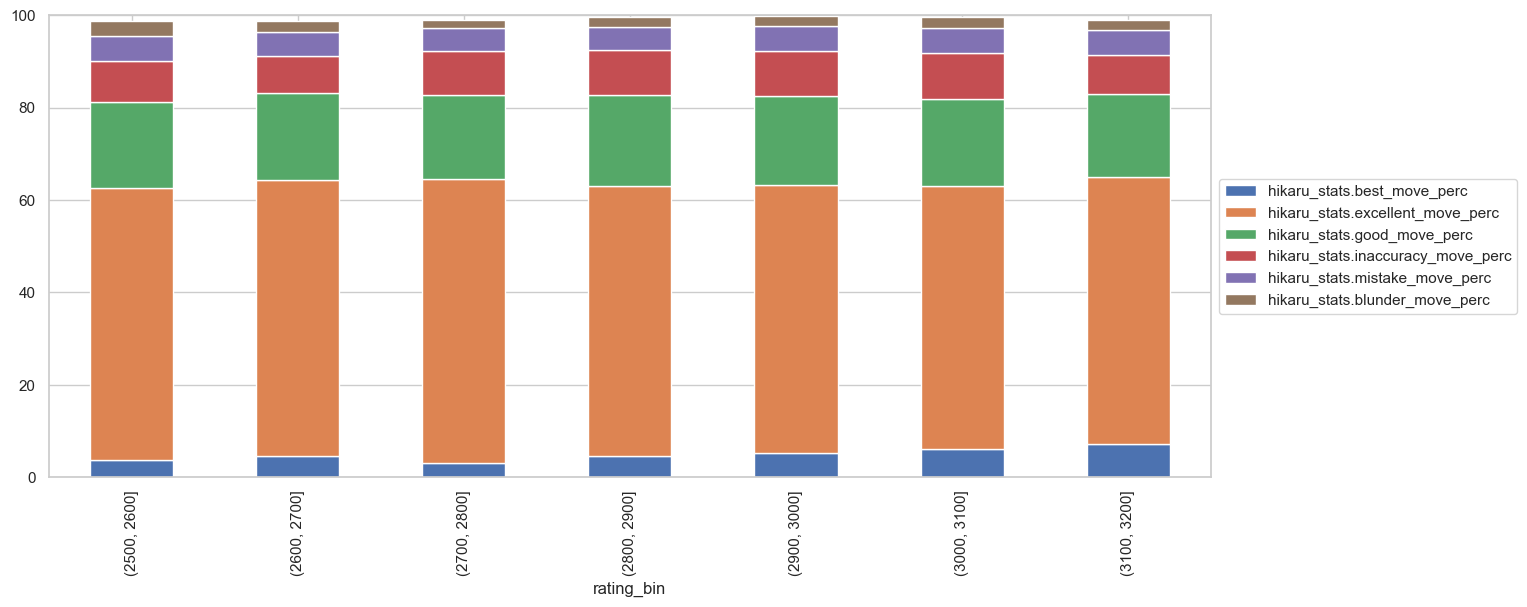

In [661]:
columns_to_stack = ['hikaru_stats.excellent_move_perc', 'hikaru_stats.best_move_perc', 'hikaru_stats.good_move_perc', 'hikaru_stats.inaccuracy_move_perc', 'hikaru_stats.mistake_move_perc', 'hikaru_stats.blunder_move_perc']

streak_games_classification_df = streak_games_df.groupby('rating_bin', observed=True).agg({
    'hikaru_stats.best_move_perc': 'mean',
    'hikaru_stats.excellent_move_perc': 'mean',
    'hikaru_stats.good_move_perc': 'mean',
    'hikaru_stats.inaccuracy_move_perc': 'mean',
    'hikaru_stats.mistake_move_perc': 'mean',
    'hikaru_stats.blunder_move_perc': 'mean'
}).reset_index()

all_blitz_no_streak_classification_df = blitz_180_no_streak_df.groupby('rating_bin', observed=True).agg({
    'hikaru_stats.best_move_perc': 'mean',
    'hikaru_stats.excellent_move_perc': 'mean',
    'hikaru_stats.good_move_perc': 'mean',
    'hikaru_stats.inaccuracy_move_perc': 'mean',
    'hikaru_stats.mistake_move_perc': 'mean',
    'hikaru_stats.blunder_move_perc': 'mean'
}).reset_index()


df_plt = all_blitz_no_streak_classification_df.set_index('rating_bin').plot(kind='bar', stacked=True, figsize=(15, 6))
df_plt.axis([4.5, 11.5, 0, 100])
df_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

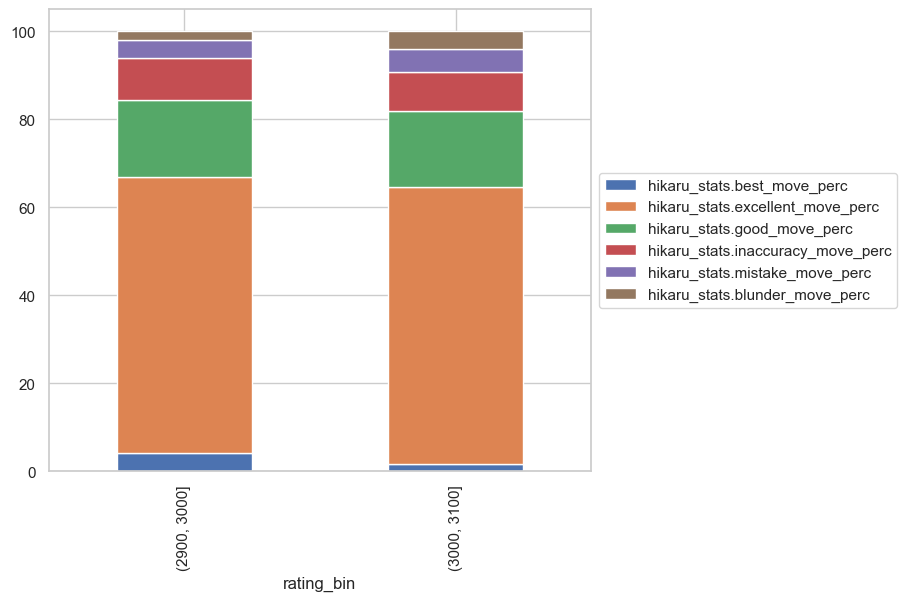

In [662]:
df_plt = streak_games_classification_df.set_index('rating_bin').plot(kind='bar', stacked=True, figsize=(7, 6))
df_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

We can tell that, as for the top 2 moves percentage, Hikaru does make good moves >80% of the time which is expected given his expertize. To be honest, I was expecting this number to be even >90%. We can also tell that "interesting" streak games do not deviate from his non streak games, if anything he makes less Best moves which is the best possible option. Let's see these numbers in table

In [663]:
numerical_columns = all_blitz_no_streak_classification_df.select_dtypes(include='number').columns
all_blitz_no_streak_classification_subset_df = all_blitz_no_streak_classification_df.iloc[9:11, :].reset_index(drop=True)
numerical_difference = streak_games_classification_df[numerical_columns] - all_blitz_no_streak_classification_subset_df[numerical_columns]


print(numerical_difference.to_markdown(headers=['Best Move Diff', 'Excellent Move Diff', 'Good Move Diff', 'Inaccuracy Move Diff', 'Mistake Move Diff', 'Blunder Move Diff']))

|    |   Best Move Diff |   Excellent Move Diff |   Good Move Diff |   Inaccuracy Move Diff |   Mistake Move Diff |   Blunder Move Diff |
|---:|-----------------:|----------------------:|-----------------:|-----------------------:|--------------------:|--------------------:|
|  0 |         -1.23431 |               4.82243 |         -1.70379 |              -0.164972 |          -1.40537   |           -0.228525 |
|  1 |         -4.49667 |               6.09158 |         -1.66513 |              -1.08642  |          -0.0851001 |            1.53457  |


So in "interesting" streak games Hikaru did make less "Best" moves for 1.2% and more excellent moves for 4.8%. If we compare this to top 2 moves percentage statistic we did before what it actually means is that Hikaru in his "interesting" streak games did make less first choice stockfish moves but more second to Nth choice stockfish moves. Also, in general, Hikaru did make less bad moves compared to his other blitz games.

Second row in this table is for range 3000 - 3100 elo range but only for 6 games played therefore not a lot of meaningful analytics can be taken out of it.

So far we saw on how Hikaru played these "interesting" streak games, but let's see how his opponents did play. We'll gather same stats we did for Hikaru for his opponents and what we are interested in is to see if his opponents during streak games did make more bad moves compared to in general opponents.

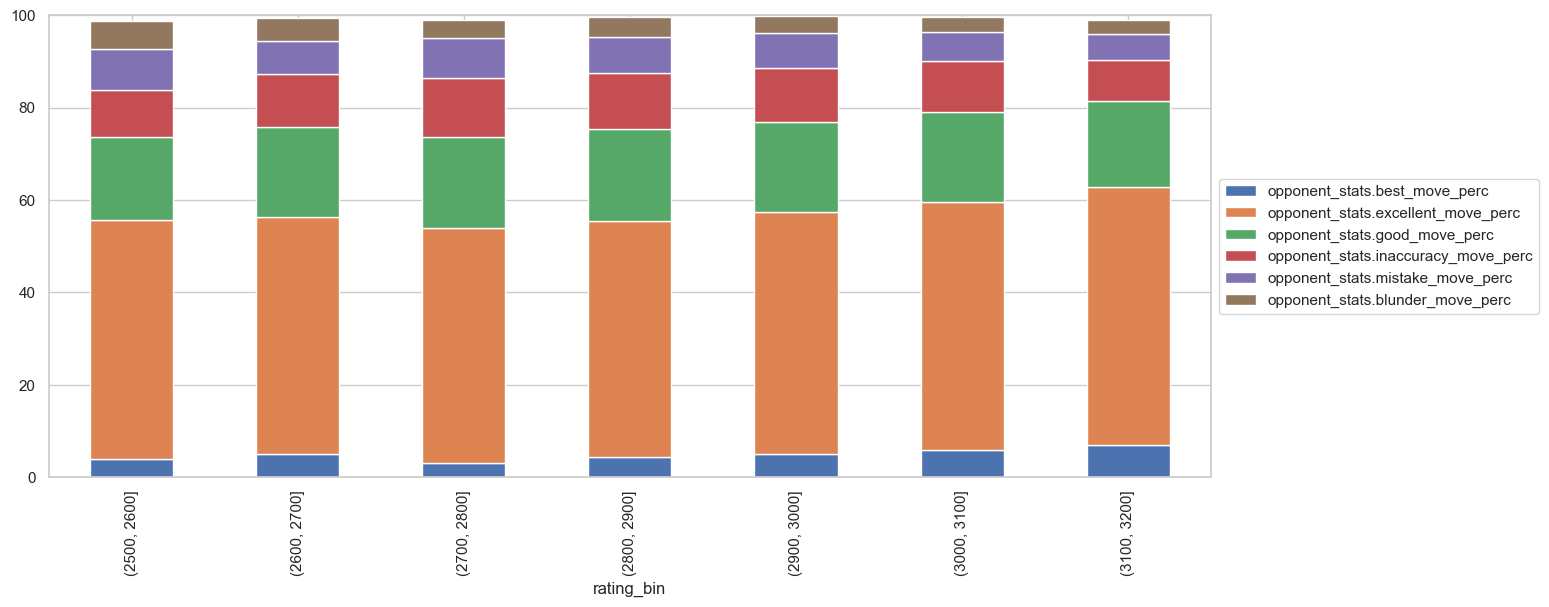

In [664]:
opponent_streak_games_classification_df = streak_games_df.groupby('rating_bin', observed=True).agg({
    'opponent_stats.best_move_perc': 'mean',
    'opponent_stats.excellent_move_perc': 'mean',
    'opponent_stats.good_move_perc': 'mean',
    'opponent_stats.inaccuracy_move_perc': 'mean',
    'opponent_stats.mistake_move_perc': 'mean',
    'opponent_stats.blunder_move_perc': 'mean'
}).reset_index()

opponent_all_blitz_no_streak_classification_df = blitz_180_no_streak_df.groupby('rating_bin', observed=True).agg({
    'opponent_stats.best_move_perc': 'mean',
    'opponent_stats.excellent_move_perc': 'mean',
    'opponent_stats.good_move_perc': 'mean',
    'opponent_stats.inaccuracy_move_perc': 'mean',
    'opponent_stats.mistake_move_perc': 'mean',
    'opponent_stats.blunder_move_perc': 'mean'
}).reset_index()


df_plt = opponent_all_blitz_no_streak_classification_df.set_index('rating_bin').plot(kind='bar', stacked=True, figsize=(15, 6))
df_plt.axis([4.5, 11.5, 0, 100])
df_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

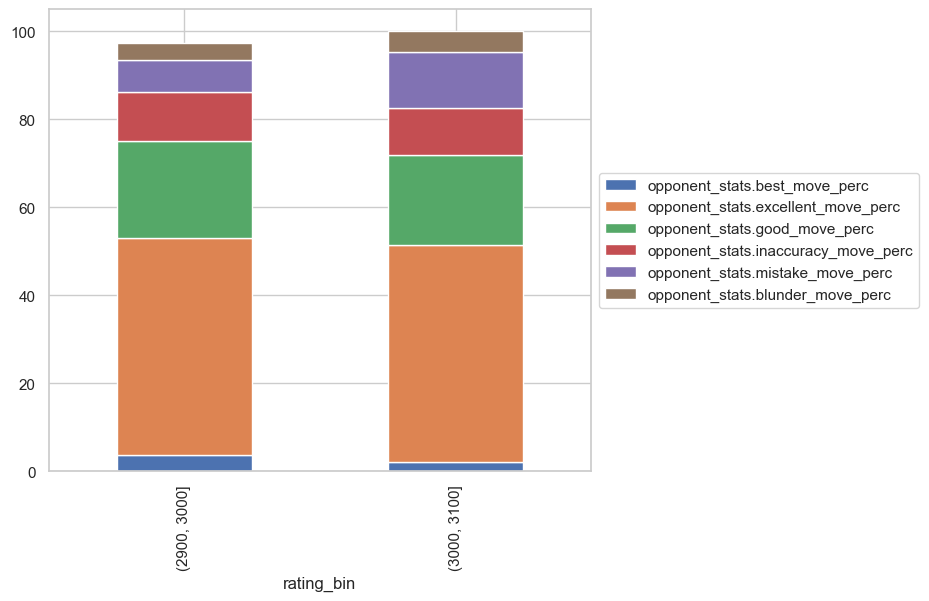

In [665]:
opponent_df_plt = opponent_streak_games_classification_df.set_index('rating_bin').plot(kind='bar', stacked=True, figsize=(7, 6))
opponent_df_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [666]:
opponent_numerical_columns = opponent_all_blitz_no_streak_classification_df.select_dtypes(include='number').columns
opponent_all_blitz_no_streak_classification_subset_df = opponent_all_blitz_no_streak_classification_df.iloc[9:11, :].reset_index(drop=True)
opponent_numerical_difference = opponent_streak_games_classification_df[opponent_numerical_columns] - opponent_all_blitz_no_streak_classification_subset_df[opponent_numerical_columns]


print(opponent_numerical_difference.to_markdown(headers=['Best Move Diff', 'Excellent Move Diff', 'Good Move Diff', 'Inaccuracy Move Diff', 'Mistake Move Diff', 'Blunder Move Diff']))

|    |   Best Move Diff |   Excellent Move Diff |   Good Move Diff |   Inaccuracy Move Diff |   Mistake Move Diff |   Blunder Move Diff |
|---:|-----------------:|----------------------:|-----------------:|-----------------------:|--------------------:|--------------------:|
|  0 |         -1.29004 |              -3.19411 |         2.67274  |              -0.73856  |           0.0598389 |          -0.0559772 |
|  1 |         -3.7651  |              -4.54486 |         0.945499 |              -0.122147 |           6.48716   |           1.29228   |


As expected, we can see that Hikaru's opponents in "interesting" streak games did make less good moves and a slightly more bad moves. In good moves category, they did more good moves which leads to evaluation loss in between 0.02 - 0.05 and did much less excellent and best moves which give better chances in game and leads to better situation. In bad moves category, they did less inaccurate moves (which is the best category in bad) and did a slightly more mistake and blunder moves.

In general all of this seems to align with what GM Hikaru Nakamura is saying about cherry-picking his opponents. Apparently these opponents do play slightly worse then the rest of the opponents Hikaru played against in same rating bucket and Hikaru is able to play better against them compared to the others. 

Let's go back to Hikaru's stats and see average thinking time per move classification.

|    | Opponent range   |   Best Move Avg |   Excellent Move Avg |   Good Move Avg |   Inaccuracy Move Avg |   Mistake Move Avg |   Blunder Move Avg |
|---:|:-----------------|----------------:|---------------------:|----------------:|----------------------:|-------------------:|-------------------:|
|  5 | (2500, 2600]     |        0.733659 |              1.71957 |         2.1784  |               2.28312 |            2.06527 |            2.16421 |
|  6 | (2600, 2700]     |        0.613577 |              2.13853 |         2.421   |               2.72779 |            2.64414 |            1.85823 |
|  7 | (2700, 2800]     |        0.626351 |              2.37723 |         2.95305 |               3.47458 |            2.71022 |            1.81851 |
|  8 | (2800, 2900]     |        0.965927 |              2.65689 |         3.45841 |               3.56333 |            3.53372 |            1.959   |
|  9 | (2900, 3000]     |        0.9802   |              2.78496 |         3.70815 |          

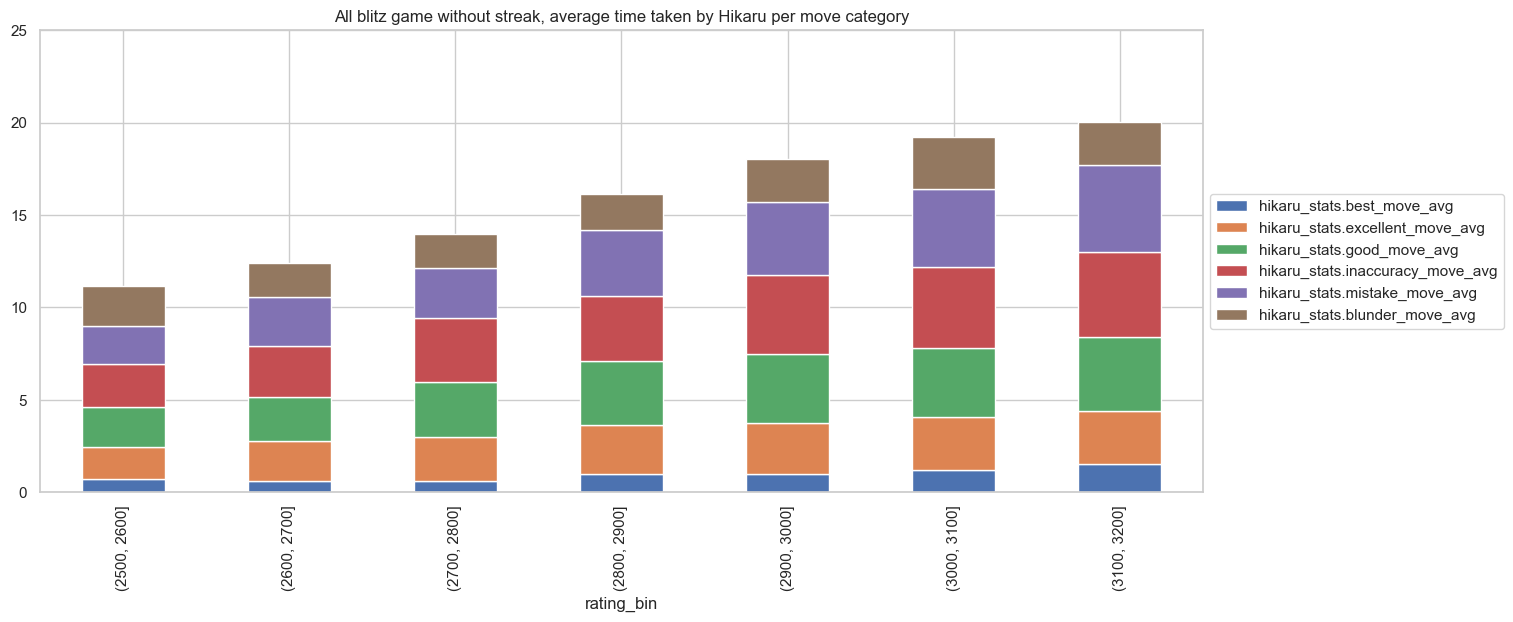

In [667]:
streak_games_time_classification_df = streak_games_df.groupby('rating_bin', observed=True).agg({
    'hikaru_stats.best_move_avg': 'mean',
    'hikaru_stats.excellent_move_avg': 'mean',
    'hikaru_stats.good_move_avg': 'mean',
    'hikaru_stats.inaccuracy_move_avg': 'mean',
    'hikaru_stats.mistake_move_avg': 'mean',
    'hikaru_stats.blunder_move_avg': 'mean'
}).reset_index()

all_blitz_no_streak_time_classification_df = blitz_180_no_streak_df.groupby('rating_bin', observed=True).agg({
    'hikaru_stats.best_move_avg': 'mean',
    'hikaru_stats.excellent_move_avg': 'mean',
    'hikaru_stats.good_move_avg': 'mean',
    'hikaru_stats.inaccuracy_move_avg': 'mean',
    'hikaru_stats.mistake_move_avg': 'mean',
    'hikaru_stats.blunder_move_avg': 'mean'
}).reset_index()

df_plt = all_blitz_no_streak_time_classification_df.set_index('rating_bin').plot(kind='bar', stacked=True, figsize=(15, 6))
df_plt.axis([4.5, 11.5, 0, 25])
df_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
df_plt.set_title('All blitz game without streak, average time taken by Hikaru per move category')

print(all_blitz_no_streak_time_classification_df.iloc[5:12, :].to_markdown(headers=['Opponent range', 'Best Move Avg', 'Excellent Move Avg', 'Good Move Avg', 'Inaccuracy Move Avg', 'Mistake Move Avg', 'Blunder Move Avg']))

From above, we can see that Hikaru spends more time thinking and playing bad moves compared to good moves which is something we also noticed when we were evaluation some of the games in 'On win' section. Also, there seems to be correlation between opponent rating range and Hikaru's thinking time on moves. As Hikaru's opponent rating increases also does his thinking time.
 
 Let's now compare these stats to "interesting" streak games and see if there is any difference in taking good/bad moves in these games compared to all blitz games.

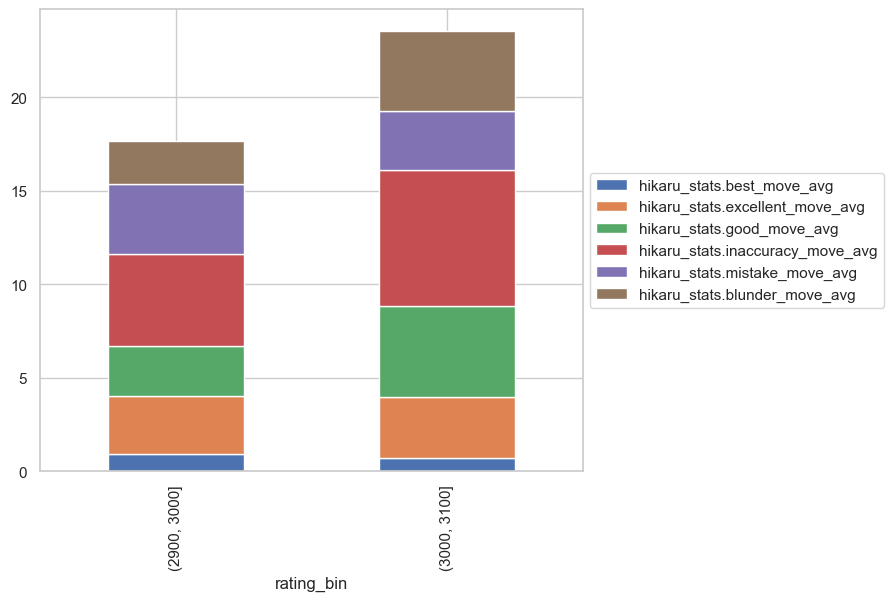

In [668]:
df_plt = streak_games_time_classification_df.set_index('rating_bin').plot(kind='bar', stacked=True, figsize=(7, 6))
df_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [669]:
numerical_columns = all_blitz_no_streak_time_classification_df.select_dtypes(include='number').columns
all_blitz_no_streak_time_classification_subset_df = all_blitz_no_streak_time_classification_df.iloc[9:11, :].reset_index(drop=True)
numerical_difference = streak_games_time_classification_df[numerical_columns] - all_blitz_no_streak_time_classification_subset_df[numerical_columns]


print(numerical_difference.to_markdown(headers=['Best Move Diff', 'Excellent Move Diff', 'Good Move Diff', 'Inaccuracy Move Diff', 'Mistake Move Diff', 'Blunder Move Diff']))

|    |   Best Move Diff |   Excellent Move Diff |   Good Move Diff |   Inaccuracy Move Diff |   Mistake Move Diff |   Blunder Move Diff |
|---:|-----------------:|----------------------:|-----------------:|-----------------------:|--------------------:|--------------------:|
|  0 |       -0.0556172 |              0.330993 |         -1.05901 |               0.661592 |           -0.251752 |           0.0184356 |
|  1 |       -0.501573  |              0.4188   |          1.13112 |               2.85505  |           -1.02701  |           1.44627   |


These numbers do not deviate a lot from 0 and given they're in seconds I do not see anything "interesting" in average time taken by move. 
<br>

So far we looked at overall games statistic. Remember that we also gathered these as per game phase, so we can see differences between endgame and middlegame stats.

In [670]:
for phase in ['middlegame', 'endgame']:
    
    streak_games_phase_classification_df = streak_games_df.groupby('rating_bin', observed=True).agg({
        f'hikaru_stats.best_{phase}_move_perc': 'mean',
        f'hikaru_stats.excellent_{phase}_move_perc': 'mean',
        f'hikaru_stats.good_{phase}_move_perc': 'mean',
        f'hikaru_stats.inaccuracy_{phase}_move_perc': 'mean',
        f'hikaru_stats.mistake_{phase}_move_perc': 'mean',
        f'hikaru_stats.blunder_{phase}_move_perc': 'mean'
    }).reset_index()
    
    
    all_blitz_no_streak_phase_classification_df = blitz_180_no_streak_df.groupby('rating_bin', observed=True).agg({
        f'hikaru_stats.best_{phase}_move_perc': 'mean',
        f'hikaru_stats.excellent_{phase}_move_perc': 'mean',
        f'hikaru_stats.good_{phase}_move_perc': 'mean',
        f'hikaru_stats.inaccuracy_{phase}_move_perc': 'mean',
        f'hikaru_stats.mistake_{phase}_move_perc': 'mean',
        f'hikaru_stats.blunder_{phase}_move_perc': 'mean'
    }).reset_index()
    
    
    numerical_columns = all_blitz_no_streak_phase_classification_df.select_dtypes(include='number').columns
    all_blitz_no_streak_phase_classification_subset_df = all_blitz_no_streak_phase_classification_df.iloc[9:11, :].reset_index(drop=True)
    numerical_difference = streak_games_phase_classification_df[numerical_columns] - all_blitz_no_streak_phase_classification_subset_df[numerical_columns]
    
    print(f'Differences in move classification percentage for phase {phase}')
    print(numerical_difference.to_markdown(headers=['Best Move Diff', 'Excellent Move Diff', 'Good Move Diff', 'Inaccuracy Move Diff', 'Mistake Move Diff', 'Blunder Move Diff']))
    print('\n')

Differences in move classification percentage for phase middlegame
|    |   Best Move Diff |   Excellent Move Diff |   Good Move Diff |   Inaccuracy Move Diff |   Mistake Move Diff |   Blunder Move Diff |
|---:|-----------------:|----------------------:|-----------------:|-----------------------:|--------------------:|--------------------:|
|  0 |       0.00154512 |               2.86386 |         -1.26991 |              -0.170392 |          -1.22153   |           -0.118101 |
|  1 |      -1.33658    |               3.17442 |         -2.93817 |              -1.05981  |          -0.0223299 |            2.4753   |


Differences in move classification percentage for phase endgame
|    |   Best Move Diff |   Excellent Move Diff |   Good Move Diff |   Inaccuracy Move Diff |   Mistake Move Diff |   Blunder Move Diff |
|---:|-----------------:|----------------------:|-----------------:|-----------------------:|--------------------:|--------------------:|
|  0 |         -2.73988 |              

Middlegame stats seems to be inline with what we saw overall as Hikaru does make a bit more excellent moves and a bit less of other moves. However, for endgame and specifically for elo rating 3000 - 3100 Hikaru did make 20% more excellent moves in streak compared to all blitz games. This may be interesting, however let's remember that 3000 - 3100 count for only 6 games so lets now see how many excellent endgame moves there was.

In [671]:
print(streak_games_df.groupby('rating_bin', observed=True).agg({
    f'hikaru_stats.excellent_endgame_move_count': 'sum',
}))

              hikaru_stats.excellent_endgame_move_count
rating_bin                                             
(2900, 3000]                                      305.0
(3000, 3100]                                       33.0


As there was 33 excellent engame moves over 6 games in this bucket it is not enough to draw any conclusion as sample size is too small to compare with all blitz games.

## Next comming...

So far we worked with data on games, basically percentages and moves aggergated on game level. However, we also have raw move stats and moving on we will be working with these as it is more granual, and we can more easily detect outlier moves. We will be also more focused on time taken metric for moves to see if there is any unusual patterns when it comes to durations of time taken.


### Bonus

As Hikaru claims that he is farming elo by cherry-picking opponents, let's put a table with these stats of all opponents who Hikaru played against at least 20 times. This may give Hikaru better insight on which opponents he wants to play when farming elo rating. You can find output file under [file](data/analysis/bonus_stats.csv).

This section is not part of analysis, it's just for fun. 

In [672]:
all_opponents = all_games_df.groupby('hikaru_stats.opponent_username').size().reset_index(name='Count')
opponents_more_then_20_games = all_opponents[all_opponents['Count'] > 20]
print(len(opponents_more_then_20_games))

filtered_by_20_games_df = all_games_df[all_games_df['hikaru_stats.opponent_username'].isin(opponents_more_then_20_games['hikaru_stats.opponent_username'])]

def first_occurrence(value_series):
    return value_series.iloc[0]

stats_df = filtered_by_20_games_df.groupby('hikaru_stats.opponent_username', observed=True).agg(
    {
        'hikaru_stats.opponent_username': first_occurrence,
        'hikaru_stats.opponent_rating': 'mean',
        'win': ['count', 'mean'],
        'timeout_win': 'mean',
        'win1': 'mean',
        'win2': 'mean',
        'win3': 'mean',
        'win4': 'mean',
        'win5': 'mean',
        'hikaru_stats.top_2_move_perc': 'mean',
        'hikaru_stats.best_move_perc': 'mean',
        'hikaru_stats.excellent_move_perc': 'mean',
        'hikaru_stats.good_move_perc': 'mean',
        'hikaru_stats.inaccuracy_move_perc': 'mean',
        'hikaru_stats.mistake_move_perc': 'mean',
        'hikaru_stats.blunder_move_perc': 'mean',
        'hikaru_stats.top_2_move_avg': 'mean',
        'hikaru_stats.best_move_avg': 'mean',
        'hikaru_stats.excellent_move_avg': 'mean',
        'hikaru_stats.good_move_avg': 'mean',
        'hikaru_stats.inaccuracy_move_avg': 'mean',
        'hikaru_stats.mistake_move_avg': 'mean',
        'hikaru_stats.blunder_move_avg': 'mean',
        'opponent_stats.top_2_move_perc': 'mean',
        'opponent_stats.best_move_perc': 'mean',
        'opponent_stats.excellent_move_perc': 'mean',
        'opponent_stats.good_move_perc': 'mean',
        'opponent_stats.inaccuracy_move_perc': 'mean',
        'opponent_stats.mistake_move_perc': 'mean',
        'opponent_stats.blunder_move_perc': 'mean'
     }
)

stats_df.to_csv('data/analysis/bonus_stats.csv', index=False, header=[
    'Opponent',
    'Opponent Elo',
    'Played count',
    'Win avg %',
    'Timeout win avg %',
    'Was loosing by >=1 but won',
    'Was loosing by >=2 but won',
    'Was loosing by >=3 but won',
    'Was loosing by >=4 but won',
    'Was loosing by >=5 but won',
    'Hikaru Top 2 Moves %',
    'Hikaru Best Move %',
    'Hikaru Excellent Move %',
    'Hikaru Good Move %',
    'Hikaru Inaccuracy Move %',
    'Hikaru Mistake Move %',
    'Hikaru Blunder Move %',
    'Hikaru Top 2 Moves Time Taken Avg',
    'Hikaru Best Move Time Taken Avg',
    'Hikaru Excellent Move Time Taken Avg',
    'Hikaru Good Move Time Taken Avg',
    'Hikaru Inaccuracy Move Time Taken Avg',
    'Hikaru Mistake Move Time Taken Avg',
    'Hikaru Blunder Move Time Taken Avg',
    'Opponent Top 2 Moves %',
    'Opponent Best Move %',
    'Opponent Excellent Move %',
    'Opponent Good Move %',
    'Opponent Inaccuracy Move %',
    'Opponent Mistake Move %',
    'Opponent Blunder Move %',
])


56


## Streak probability

### P-value
TBD
### Bayes
TBD